/home/20223176/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/20223176/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


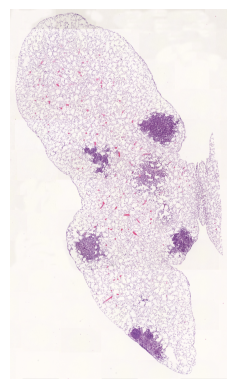

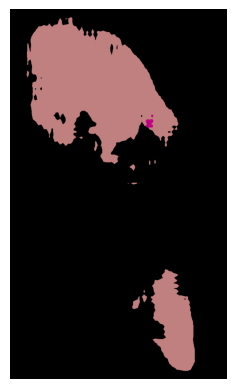

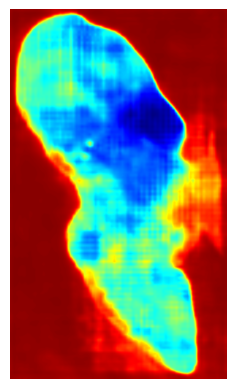

In [1]:
import torch
import torchvision.transforms as T
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
# Define the helper function
def decode_segmap(image, nc=21):
  
    label_colors = np.array([(0, 0, 0),  # 0=background
               # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               # 11=dining table, 12=dog, 13=horse, 14=motorbike, 15=person
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, nc):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

def segment_and_entropy(net, path, show_orig=True, classes=-1, dev='cuda'):
    img = Image.open(path)
    if show_orig: plt.imshow(img); plt.axis('off'); plt.show()
    # Comment the Resize and CenterCrop for better inference results
    trf = T.Compose([T.Resize(640), 
                   #T.CenterCrop(224), 
                   T.ToTensor(), 
                   T.Normalize(mean = [0.485, 0.456, 0.406], 
                               std = [0.229, 0.224, 0.225])])
    inp = trf(img).unsqueeze(0).to(dev)
    out = net.to(dev)(inp)['out']
    om = torch.argmax(out.squeeze(), dim=0).detach().cpu().numpy()
    rgb = decode_segmap(om)
    plt.imshow(rgb); plt.axis('off'); plt.show()
    
    out_soft = torch.softmax(out, dim=1)    
    entropy_map = -out_soft * torch.log(out_soft + 1e-6)
        
    if classes == -1:
        entropy_map = torch.sum(entropy_map, dim=1)
    else:
        indices = torch.tensor(classes)
        entropy_map = torch.index_select(entropy_map, 1, indices)
        entropy_map = torch.sum(entropy_map, dim=1)
    
    # opencv version of jetmap entropy
    entropy_map = entropy_map.squeeze(0)
    entropy_map = entropy_map.cpu().detach().numpy()
    entropy_map = entropy_map / np.max(entropy_map) * 255
    entropy_map = entropy_map.astype(np.uint8)
    entropy_map = cv2.applyColorMap(entropy_map, cv2.COLORMAP_JET)
    # entropy_map = entropy_map.cpu().detach().numpy()
    plt.imshow(entropy_map, cmap=plt.cm.jet); plt.axis('off'); plt.show()
    # entropy = np.sum(entropy_map)
    
    return entropy_map

dlab = models.segmentation.deeplabv3_resnet101(pretrained=1).eval()
path = "lung-lobes_1/scale-50pc/29-039-U-35W-Izd1-1-HE.jpg" # 이미지 경로

# 전체 클래스에 대한 entropy 계산
entropy = segment_and_entropy(dlab, path, classes=-1)
# 특정 클래스에 대한 entropy 계산
# entropy = segment_and_entropy(dlab, path, classes=[0, 3, 5])



In [2]:
import torch
import cv2
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from lightglue import LightGlue, SuperPoint
from lightglue.utils import rbd
from lightglue import viz2d

def elastic_transform(image, alpha, sigma):
    shape = image.shape[:2]
    dx = cv2.GaussianBlur((np.random.rand(*shape) * 2 - 1), (0, 0), sigma) * alpha
    dy = cv2.GaussianBlur((np.random.rand(*shape) * 2 - 1), (0, 0), sigma) * alpha
    
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    x_new = np.clip(x + dx, 0, shape[1] - 1).astype(np.float32)
    y_new = np.clip(y + dy, 0, shape[0] - 1).astype(np.float32)
    
    transformed = cv2.remap(image, x_new, y_new, interpolation=cv2.INTER_LINEAR)
    return transformed, dx, dy

/home/20223176/.local/lib/python3.8/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
2025-02-04 11:37:50.765958: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def extract_keypoints_and_matches(image0, image1, extractor, matcher):
    feats0 = extractor.extract(torch.tensor(image0).unsqueeze(0).to(device))
    feats1 = extractor.extract(torch.tensor(image1).unsqueeze(0).to(device))
    matches01 = matcher({"image0": feats0, "image1": feats1})
    
    feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]
    kpts0, kpts1, matches = feats0["keypoints"], feats1["keypoints"], matches01["matches"]
    m_kpts0, m_kpts1 = kpts0[matches[..., 0]], kpts1[matches[..., 1]]
    
    return m_kpts0.cpu().numpy(), m_kpts1.cpu().numpy()

def extract_patches(image, keypoints, patch_size=32):
    patches = []
    h, w = image.shape[:2]
    half = patch_size // 2
    for (x, y) in keypoints:
        x, y = int(x), int(y)
        x1, y1 = max(0, x - half), max(0, y - half)
        x2, y2 = min(w, x + half), min(h, y + half)
        patch = image[y1:y2, x1:x2]
        patch = cv2.resize(patch, (patch_size, patch_size))
        patches.append(patch)
    return np.array(patches)

class PatchDataset(Dataset):
    def __init__(self, npz_file):
        data = np.load(npz_file)
        self.patches0 = torch.tensor(data['patches0'], dtype=torch.float32).unsqueeze(1)
        self.patches1 = torch.tensor(data['patches1'], dtype=torch.float32).unsqueeze(1)
        self.gt = torch.tensor(data['gt'], dtype=torch.float32)
    
    def __len__(self):
        return len(self.gt)
    
    def __getitem__(self, idx):
        return torch.cat((self.patches0[idx], self.patches1[idx]), dim=0), self.gt[idx]

NameError: name 'Dataset' is not defined

In [7]:
from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image, rbd
from lightglue import viz2d
import torch
import pandas as pd
import os
num_augmentations = 100
from pathlib import Path

images = Path("lung-lobes_1/scale-50pc")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'

extractor = SuperPoint(max_num_keypoints=1024).eval().to(device)  # load the extractor
matcher = LightGlue(features="superpoint").eval().to(device)

In [12]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("javidtheimmortal/hpatches")

print("Path to dataset files:", path)

100%|██████████| 4.16G/4.16G [03:30<00:00, 21.3MB/s]

Extracting model files...


Path to dataset files: /home/20223176/.cache/kagglehub/datasets/javidtheimmortal/hpatches/versions/1


In [8]:
num_augmentations = 100
results = []
image0 = cv2.imread(images / "29-039-U-35W-Izd1-1-HE.jpg", cv2.IMREAD_GRAYSCALE)
image0 = image0 / 255.0 if image0.max() > 1 else image0

# Apply Elastic Transformation
image1, dx, dy = elastic_transform(image0, alpha=30, sigma=5)

# Initialize extractor and matcher
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
extractor = SuperPoint().to(device)
matcher = LightGlue().to(device)

feats0 = extractor.extract(torch.tensor(image0).unsqueeze(0).to(device))
feats0_copy = rbd(feats0)  
kpts0 = feats0_copy["keypoints"].cpu().numpy()

for i in range(num_augmentations):
    seed = i
    image1_aug, transform_matrix = elastic_transform(image0, alpha=30, sigma=5)
    image1_aug = torch.tensor(image1_aug).to(device)
    
    feats1 = extractor.extract(image1_aug)
    matches01 = matcher({"image0": feats0, "image1": feats1})
    feats1 = rbd(feats1)
    matches01 = rbd(matches01)

    kpts1 = feats1["keypoints"]
    matches = matches01["matches"]
    matches = torch.tensor(matches, dtype=torch.long) if isinstance(matches, list) else matches

    if matches.shape[0] == 0:
        print(f"No matches found for seed {seed}. Skipping...")
        continue

    m_kpts0 = kpts0[matches.cpu().numpy()[:, 0]]  
    m_kpts1 = kpts1[matches.cpu().numpy()[:, 1]].cpu().numpy()
    recovered_points = m_kpts0 + np.stack([dx[m_kpts0[:, 1].astype(int), m_kpts0[:, 0].astype(int)],
                                            dy[m_kpts0[:, 1].astype(int), m_kpts0[:, 0].astype(int)]], axis=-1)

    for pt0, pt1, rec_pt in zip(m_kpts0, m_kpts1, recovered_points):
        results.append({
            "image0_x": pt0[0], "image0_y": pt0[1],
            "image1_x": pt1[0], "image1_y": pt1[1],
            "recovered_x": rec_pt[0], "recovered_y": rec_pt[1],
            "seed": seed  
        })

# Save results to CSV
df = pd.DataFrame(results)
df.to_csv("matched_coordinates_elastic.csv", index=False)

error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'remap'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


In [ ]:
num_augmentations = 100
results = []
image0 = cv2.imread("he_original.png", cv2.IMREAD_GRAYSCALE)
image0 = image0 / 255.0 if image0.max() > 1 else image0

# Apply Elastic Transformation
image1, dx, dy = elastic_transform(image0, alpha=30, sigma=5)

# Initialize extractor and matcher
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
extractor = SuperPoint().to(device)
matcher = LightGlue().to(device)

feats0 = extractor.extract(torch.tensor(image0).unsqueeze(0).to(device))
feats0_copy = rbd(feats0)  
kpts0 = feats0_copy["keypoints"].cpu().numpy()

for i in range(num_augmentations):
    seed = i
    image1_aug, transform_matrix = elastic_transform(image0, alpha=30, sigma=5)
    image1_aug = torch.tensor(image1_aug).to(device)
    
    feats1 = extractor.extract(image1_aug)
    matches01 = matcher({"image0": feats0, "image1": feats1})
    feats1 = rbd(feats1)
    matches01 = rbd(matches01)

    kpts1 = feats1["keypoints"]
    matches = matches01["matches"]
    matches = torch.tensor(matches, dtype=torch.long) if isinstance(matches, list) else matches

    if matches.shape[0] == 0:
        print(f"No matches found for seed {seed}. Skipping...")
        continue

    m_kpts0 = kpts0[matches.cpu().numpy()[:, 0]]  
    m_kpts1 = kpts1[matches.cpu().numpy()[:, 1]].cpu().numpy()
    recovered_points = m_kpts0 + np.stack([dx[m_kpts0[:, 1].astype(int), m_kpts0[:, 0].astype(int)],
                                            dy[m_kpts0[:, 1].astype(int), m_kpts0[:, 0].astype(int)]], axis=-1)

    for pt0, pt1, rec_pt in zip(m_kpts0, m_kpts1, recovered_points):
        results.append({
            "image0_x": pt0[0], "image0_y": pt0[1],
            "image1_x": pt1[0], "image1_y": pt1[1],
            "recovered_x": rec_pt[0], "recovered_y": rec_pt[1],
            "seed": seed  
        })

# Save results to CSV
df = pd.DataFrame(results)
df.to_csv("matched_coordinates_elastic.csv", index=False)


In [3]:

dataset = PatchDataset("dataset.npz")
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define training loop
def train_model(model, dataloader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for patches, gt in dataloader:
            patches, gt = patches.to(device), gt.to(device)
            optimizer.zero_grad()
            output = model(patches)
            loss = criterion(output, gt)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader):.4f}")

# Train model
train_model(model, dataloader, criterion, optimizer, epochs=10)

SyntaxError: unexpected EOF while parsing (2288173697.py, line 1)